In [9]:
import os
import tifffile as tf
import skimage.morphology as morph
import skimage.filters as filt
import numpy as np
import scipy.ndimage as nd
import skimage.feature as feat
from pathos.multiprocessing import ProcessingPool
from functools import partial
import glob
import time

%matplotlib notebook
import matplotlib.pyplot as plt

In [26]:
def denoiseImage(img,*kwargs):
    """
    Denoise image by subtracting laplacian of gaussian
    """
    img_gaus = filt.gaussian(img,sigma=3)
    img_log = filt.laplace(img_gaus) #laplacian filter
    denoised_img = img - img_log # noise subtraction
    denoised_img[denoised_img < 0] = 0 # no negative pixels
    return denoised_img.astype(np.uint8)

def padImages(img,*kwargs):
    hoff,voff = 35,3
    newimg = np.pad(img,((voff,voff),(hoff,hoff)),'constant',constant_values = 0)
    return newimg

def unpadImages(img,*kwargs):
    hoff,voff = 35,3
    newimg = img[voff:-voff:1,hoff:-hoff:1]
    return newimg

def singleChannel_falseColor(input_image,channelID,output_dtype = np.uint8):
    """
    single channel false coloring based on:
        Giacomelli et al., PLOS one 2016 doi:10.1371/journal.pone.0159337
    """
    
    beta_dict = {'cytoplasm' : {'K' : 0.008,
                              'R' : 0.300,
                              'G' : 1.000,
                              'B' : 0.860},
                 'nuclei' : {'K' : 0.017,
                             'R' : 0.544,
                             'G' : 1.000,
                             'B' : 0.050}}
    
    
    RGB_image = np.zeros((input_image.shape[0],input_image.shape[1],3))
    
    
    constants = beta_dict[channelID]
    
    R = np.exp(-constants['K']*constants['R']*input_image)
    G = np.exp(-constants['K']*constants['G']*input_image)
    B = np.exp(-constants['K']*constants['B']*input_image)
    
    RGB_image[:,:,0] = R*255
    RGB_image[:,:,1] = G*255
    RGB_image[:,:,2] = B*255
    
    return RGB_image.astype(output_dtype)

def combineFalseColoredChannels(cytoplasm,nuclei,norm_factor = 255,output_dtype = np.uint8):
    
    assert(cytoplasm.shape == nuclei.shape)
 
    RGB_image = np.multiply(cytoplasm/norm_factor,nuclei/norm_factor)
    RGB_image = np.multiply(RGB_image,norm_factor)
    
    return RGB_image.astype(output_dtype)
    
    

def falseColor(cytosol,nuclei):
    cytosol = np.power(cytosol,0.85)
    nuclei = np.power(nuclei,0.85)

    k_cytoplasm=0.008
    k_nuclei=0.017
    
    beta1=0.860
    beta2=0.050
    
    beta3=1.0
    beta4=1.0
    
    beta5=0.300
    beta6=0.544
    
    
    R = np.multiply(np.exp(-beta5*k_cytoplasm*cytosol),np.exp(-beta6*k_nuclei*nuclei))
    G = np.multiply(np.exp(-beta3*k_cytoplasm*cytosol),np.exp(-beta4*k_nuclei*nuclei))
    B = np.multiply(np.exp(-beta1*k_cytoplasm*cytosol),np.exp(-beta2*k_nuclei*nuclei))
    image = np.zeros((cytosol.shape[0],cytosol.shape[1],3))
    image[:,:,0] = (R*255)
    image[:,:,1] = (G*255)
    image[:,:,2] = (B*255)
    image = image.astype(np.uint8)
    return image.astype(np.uint8)
    

In [27]:
colorSingle_runnable = {'runnable' : singleChannel_falseColor}

In [28]:


class DataObject(object):
    def __init__(self,directory, imageSet = None, channel_IDs = None, setupPool = False):
        """
        Object to store image data in a convienient way for batch processing
        
        Attributes
        ----------
        
        directory : string
            Base directory where image data is stored
            
        imageSet : dict
            default None, if passed the directory structure should be 
            
            imageSet = {'channel_name' : {
                                        'data' : np.array, #image data
                                        'files : list #list of file names ending in
                                        }
                        ....}
        
        channel_IDs : list
            list of channel names i.e ['channel1','channel2'...]
            used to sort data
        
        setupPool : bool
            setup processing pool
        
        
        """
        
        #object base directory
        self.directory = directory
        
        
        #channel IDs are expected to be a list
        if channel_IDs:
            self.channel_IDs = channel_IDs
        else:
            self.channel_IDs = []
        
        
        if imageSet:
            self.imageSet = imageSet
        else:
            self.imageSet = {}
        
        
        if setupPool:
            self.setupProcessing(ncpus = 2)
        else:
            self.unloadPool()
                
    
    def loadImages(self,file_list,image_size,channel_ID):            
        try:
            assert(type(image_size == tuple))
            assert(len(image_size) > 0)
            file_list = sorted(file_list)
            file_names = []
            images = np.zeros((len(file_list),image_size[0],image_size[1]))

            for i,z in enumerate(file_list):
                images[i] = tf.imread(z)
                file_names.append(z.split(os.sep)[-1])
            
            if channel_ID not in self.imageSet.keys():
                self.imageSet[channel_ID] = {}
            
            self.imageSet[channel_ID]['data'] = images
            self.imageSet[channel_ID]['files'] = file_names
        
        except AssertionError:
            print('Image_size must be tuple of form (m,n) where m and n are integers')
    
    def setupProcessing(self,ncpus):
        self.pool = ProcessingPool(ncpus=ncpus)
        
    def unloadPool(self):
        self.pool = None
    
    def processImages(self,runnable_dict, channel_IDs):
        """
        Purpose
        -------
        Method to batch process multiple images simultaneously. Can process multiple 
        channels or one at a time. Method acts on Image data within data object. 
        
        Attributes
        ----------
        
        runnable_dict : dict
            Currently should have one key 'runnable' which is mapped to a method to be run
        
        channel_IDs : list
            list of strings which correspond to keys in imageSet dictonary
        
        """
        to_unload = False
        if self.pool is None:
            to_unload = True
            self.setupProcessing(ncpus=4)
        
        processed_images = {}
            
        for chan in channel_IDs:
            print(chan)
            
            #data set to be acted upon
            images = self.imageSet[chan]['data'] 
            
            #allows setting of keyword arguments in runnable beforehand as one function for map
            method = partial(runnable_dict['runnable'],channelID = chan)
            
            #map runnable, processed images will be a dictonary with channel IDs as keys
            #each key is mapped to the corresponding image array
            processed_images[chan] = np.asarray(self.pool.map(method,images))
        
        if to_unload:
            #unload pools
            self.unloadPool()
        
        return processed_images
        

In [29]:
file_path = "/Users/robertserafin/Desktop/Cell_Counting_Practice_Data/Background_subtracted_allen_data/04_R/Stack"

nuclei_files = [os.path.join(file_path,f) for f in os.listdir(file_path) if 'ch01' in f]
cyto_files = [os.path.join(file_path,f) for f in os.listdir(file_path) if 'ch02' in f]

In [30]:
data = None
data = DataObject(directory=file_path,channel_IDs=['cytoplasm','nuclei'])
data.loadImages(nuclei_files,(1960, 1960),'nuclei')
data.loadImages(cyto_files,(1960, 1960),'cytoplasm')

<IPython.core.display.Javascript object>


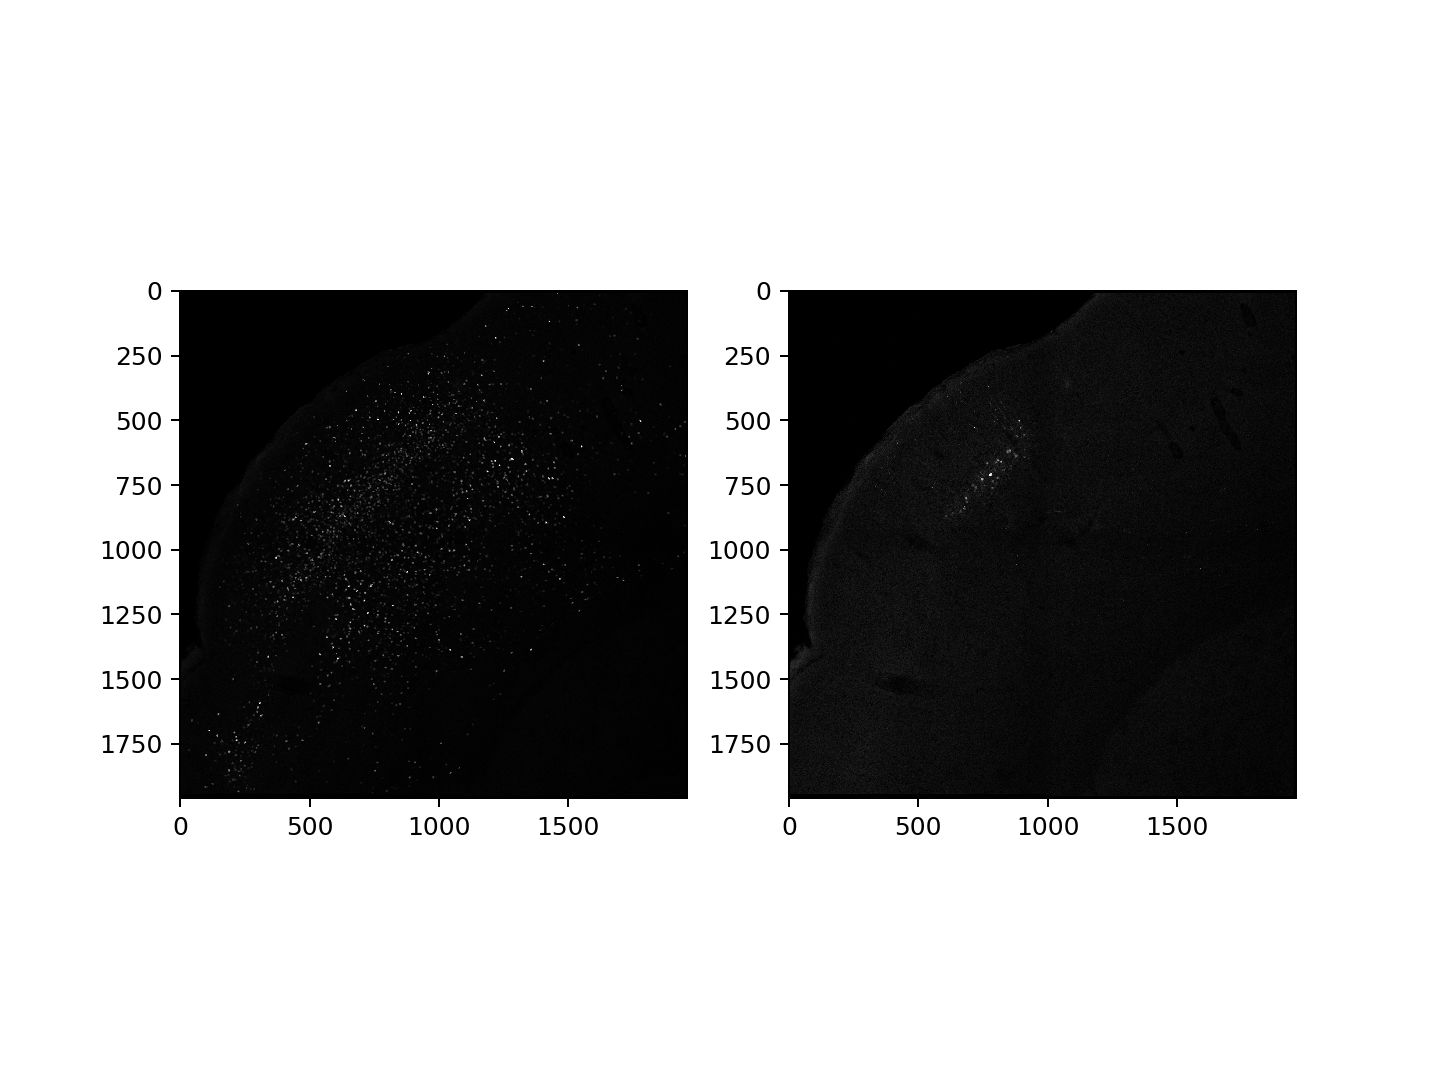

In [31]:
img1 = data.imageSet['nuclei']['data'][10]
img2 = data.imageSet['cytoplasm']['data'][10]
f,ax = plt.subplots(ncols =2,figsize = (8,6))
ax[0].imshow(img1, cmap = 'gray')
ax[1].imshow(img2, cmap = 'gray')

In [16]:
t0 = time.time()
false_colored_data = data.processImages(colorSingle_runnable,['nuclei','cytoplasm'])
print(time.time() - t0)

nuclei
cytoplasm
5.954447984695435


In [ ]:
false_colored_data['nuclei'][0].shape,false_colored_data['cytoplasm'][10].shape

In [ ]:
final_data = combineFalseColoredChannels(false_colored_data['cytoplasm'],false_colored_data['nuclei'])


In [ ]:
for i in range(len(final_data)):
    plt.subplots(figsize = (8,8))
    plt.imshow(final_data[i])

In [ ]:
plt.close('all')

uint8


<IPython.core.display.Javascript object>


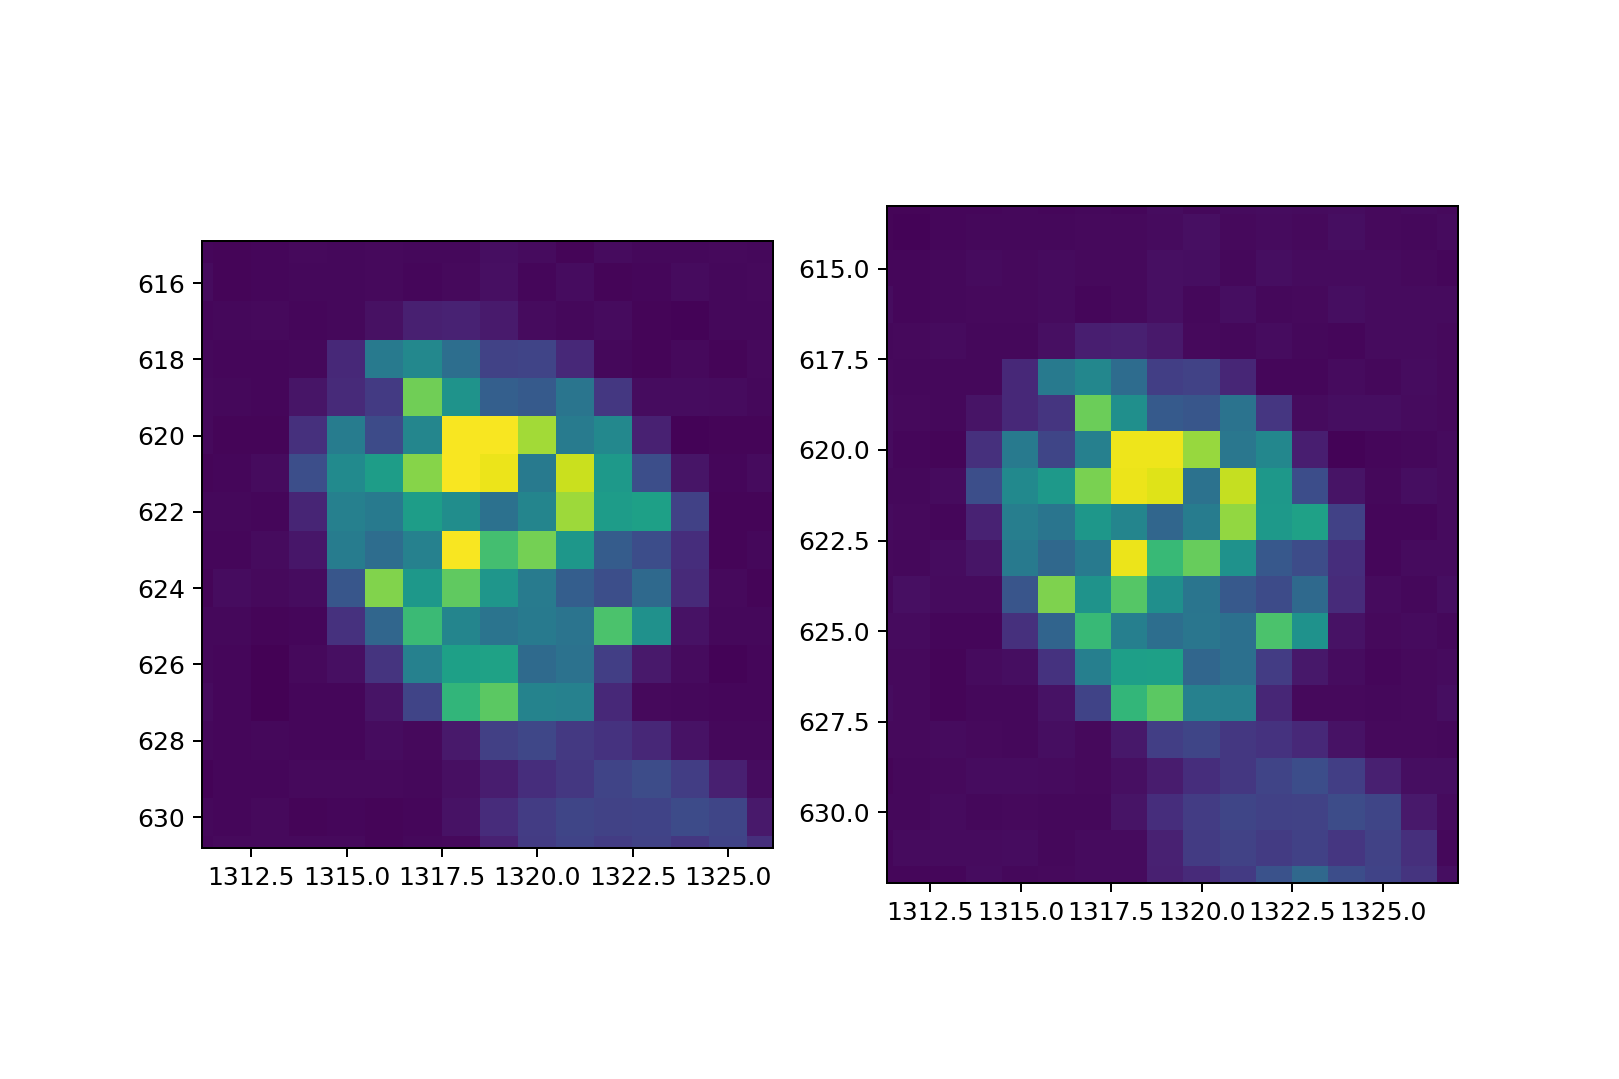

In [32]:
trialImg = data.imageSet['nuclei']['data'][10]

trial_denoised = denoiseImage(trialImg)
print(trial_denoised.dtype)

f,ax = plt.subplots(ncols = 2,figsize = (9,6))
ax[0].imshow(trialImg)
ax[1].imshow(trial_denoised)